In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from pytesseract import pytesseract
import os

In [34]:
def find_plate(img, th_img):
    contours, hierarchy = cv.findContours(th_img, cv.RETR_EXTERNAL,
                                                cv.CHAIN_APPROX_SIMPLE)

    area = -1
    x_plate, y_plate, w_plate, h_plate = 0, 0, 0, 0
    plate_cnt = None

    for cnt in contours:
        x, y, w, h = cv.boundingRect(cnt)
        aspect = w / h
        if aspect > 3 and aspect < 7:
            count_area = cv.contourArea(cnt)
            if count_area > area:
                area = count_area
                x_plate, y_plate, w_plate, h_plate = x, y, w, h
                plate_cnt = cnt

    rect = cv.minAreaRect(plate_cnt)
    box = cv.boxPoints(rect)
    box = np.intp(box)

    angle = rect[2]
    if angle > 45:
        angle = angle - 90
    elif angle < -45:
        angle = 90 + angle
        
    if rect[1][0] < rect[1][1]:
        angle += 90

    (h, w) = img.shape
    M = cv.getRotationMatrix2D(rect[0], angle, 1.0)
    rotated = cv.warpAffine(img, M, (w, h), flags=cv.INTER_CUBIC)
    x, y, w, h = cv.boundingRect(cv.boxPoints(((rect[0]), (rect[1]), 0)))
    cropped = rotated[y:y+h, x:x+w]
    return cropped

In [20]:
def find_plate_2(img, debug=False):
    _, th_img = cv.threshold(img, 100, 255, cv.THRESH_BINARY)
    contours, _ = cv.findContours(th_img, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    
    plate_cnt = None
    best_area = 0
    contour_img = img.copy()

    for cnt in contours:
        x, y, w, h = cv.boundingRect(cnt)
        cv.rectangle(contour_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        aspect = w / h if h != 0 else 0
        area = cv.contourArea(cnt)

        if 2.5 < aspect < 8.0 and area > best_area and area < 5000:
            best_area = area
            plate_cnt = cnt
            
    if debug:
        plt.imshow(th_img, cmap="gray")
        plt.show()
        plt.imshow(contour_img, cmap="gray")
        plt.show()
        
    if debug:
        print("AREA = ", best_area)

    if plate_cnt is None:
        return None

    rect = cv.minAreaRect(plate_cnt)
    (cx, cy), (w, h), angle = rect

    if w < h:
        angle += 90
        w, h = h, w

    if angle > 170:
        angle -= 180
    
    if debug:
        print("ANGLE = ", angle)

    M = cv.getRotationMatrix2D((cx, cy), angle, 1.0)
    rotated = cv.warpAffine(img, M, (img.shape[1], img.shape[0]), flags=cv.INTER_CUBIC)
    box = cv.boxPoints(((cx, cy), (w, h), 0))
    box = np.intp(box)
    x, y, w, h = cv.boundingRect(box)

    cropped = rotated[y:y+h, x:x+w]

    if cropped.shape[0] > cropped.shape[1]:
        cropped = cv.rotate(cropped, cv.ROTATE_90_CLOCKWISE)

    cropped = cv.equalizeHist(cropped)
    
    return cv.resize(cropped, (120, 30))

1) 5,10 -> 25,20
2) 0,22 -> 25,35
3) 0,36 -> 25,46
4) 0,47 -> 25,60
5) 5,62 -> 25, 76
6) 5,77 -> 25,89
7) 0,95 -> 15,104
8) 0,105 -> 15,117

In [3]:
def segment_characters(img):
    images = [None] * 8
    images[0] = img[7:25, 7:19]
    images[1] = img[0:25, 22:35]
    images[2] = img[0:25, 36:46]
    images[3] = img[0:25, 47:60]
    images[4] = img[5:25, 61:75]
    images[5] = img[5:25, 75:86]
    images[6] = img[2:18, 93:103]
    images[7] = img[2:18, 103:113]

    return images


In [9]:
def get_best_symb(img, patterns):
    char_mapping = {"a":"а", "b":"б", "c":"с", "e":"е", "h":"х", 
                    "k":"к", "m":"м", "n":"н", "o":"о", "r":"р", "t":"т", "u":"у"}
    best_score = -1
    best_char = None
    for key, tmpl in patterns.items():
        # масштабируем шаблон под размер символа
        tmpl_resized = cv.resize(tmpl, (img.shape[1], img.shape[0]))
        res = cv.matchTemplate(img, tmpl_resized, cv.TM_CCORR_NORMED)
        score = res[0][0]
        #print(i, key, score)
        if score > best_score:
            best_score = score
            best_char = key
    if best_char != None and best_char.isalpha():
        best_char = char_mapping[best_char]
    return best_char

def recognise_pattern(symbol_img, num_patterns, char_patterns):
    plate_nums = []
    plate_chars = []

    num_indx = [1, 2, 3, 6, 7]
    char_idx = [0, 4, 5]
    for i in num_indx:
        plate_nums.append(get_best_symb(symbol_img[i], num_patterns))

    for j in char_idx:
        plate_chars.append(get_best_symb(symbol_img[j], char_patterns))

    return "".join(plate_chars[0]) + "".join(plate_nums[0:3]) + "".join(plate_chars[1:]) + "".join(plate_nums[3:])


In [6]:
chars_templates = {}
numbers_templates = {}
folder_path = "../plates_symb"
for filename in os.listdir(folder_path):
    # Проверяем расширение файла
    if filename.lower().endswith(('.jpg', '.jpeg')):

        file_path = os.path.join(folder_path, filename)
        image = cv.imread(file_path, cv.IMREAD_GRAYSCALE)

        name = filename.split(".")[0]
        if name.isdigit():
            numbers_templates[name] = image
        else:
            chars_templates[name] = image


In [41]:
def preprocces_symb_img(sym_img, min_thresh):
    kernel = np.ones((1, 1), np.uint8)
    _, thresh_img = cv.threshold(sym_img, min_thresh, 255, cv.THRESH_BINARY)
    img_erosion = cv.erode(thresh_img, kernel, iterations=2)
    return img_erosion

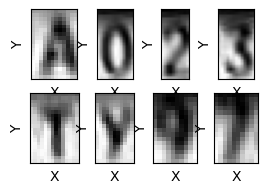

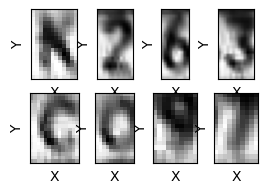

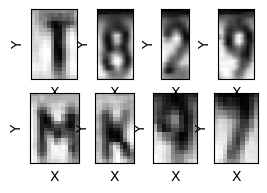

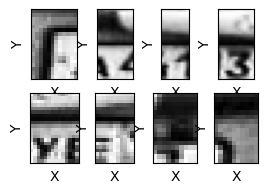

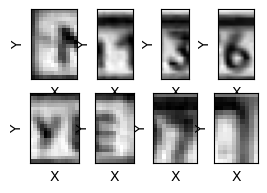

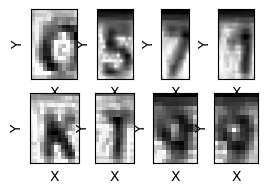

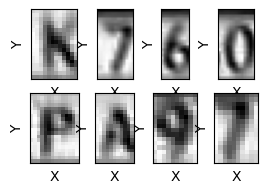

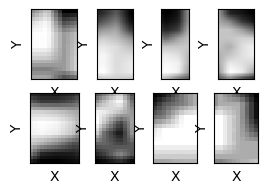

In [ ]:
#вырезать побольше цифры, пройтись несколько раз по кропнутому изображению чтобы определить 

img_count = 8

for i in range(1, img_count + 1):
    img = cv.imread(f"../car_plates_img/car_p_{i}.jpg")
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    cropped_img = find_plate_2(img)

    if(cropped_img is None):
        continue

    cropped_img = find_plate_2(img, False)
    nums = segment_characters(cropped_img)
    # nums = [preprocces_symb_img(x, 120) for x in nums]

    plate = recognise_pattern(nums, numbers_templates, chars_templates)
    fig, axes = plt.subplots(2, 4, figsize=(3, 2))
    for i, ax in enumerate(axes.flat):
        
        if i < len(nums):
            im = ax.imshow(nums[i], cmap='gray')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            # Убираем метки осей для экономии места
            ax.set_xticks([])
            ax.set_yticks([])
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    # ax1.imshow(img, cmap="gray")
    # ax1.set_title(f'Исходное изображение {i}')
    # ax1.axis('off')

    # ax2.imshow(cropped_img, cmap="gray")
    # ax2.set_title(f'Вырезанная часть {i}')
    # ax2.axis('off')

    # ax1.set_aspect('equal')
    # ax2.set_aspect('equal')
    # print(plate)
    # fig, ax = plt.subplots(1, 1, figsize=(5,3))
    # ax.imshow(cropped_img, cmap="gray")

    # plt.tight_layout()
    # plt.show()

